# Seminar 4: Transfer Learning

Today's theory in two pictures:

![transfer learning meme](https://user-images.githubusercontent.com/9570420/113611523-522e0180-9657-11eb-919a-639c398740b1.png)
![transfer learning diagram](https://user-images.githubusercontent.com/9570420/113617617-362e5e00-965f-11eb-9eeb-f433e780dd00.png)

Now to the practice!

Transfer learning from a large dataset is almost always better than training from scratch on a small dataset directly. It prevents overfitting and increases accuracy. We will review three methods of transfer learning.

The plan:

1. Review our target task, i.e. small dataset — telling apart architectural heritage elements on images.
2. Review our (far more complex) source task — 1000-class [ImageNet](http://image-net.org/) classification. Download a CNN pretrained on it.
3. Use that CNN as a black box feature extractor. Namely, train a classical ML model on outputs of CNN's next to last layer to solve the target task.
4. Retrain CNN's last layers only for the target task.
5. Train (*fine-tune*) the whole network for the target task.

*(service code)* Import libraries.

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

import torch
import torchvision

### 1. Architectural Heritage Elements Dataset

*(service code)* Download the dataset.

In [ ]:
from pathlib import Path

DATASET_ROOT = Path("Architectural_Heritage_Elements_Dataset_128(creative_commons)")
!pip install -U gdown

if not (DATASET_ROOT / "train").is_dir():
    !gdown --id 1X38ZkQnox_k0BaYtMlApFmT7oxAK_c9F

    ARCHIVE_NAME = Path("architectural_heritage_elements.zip")
    assert ARCHIVE_NAME.is_file(), f"Couldn't download {ARCHIVE_NAME} doesn't exist"

    print("Unzipping...")
    import zipfile
    with zipfile.ZipFile(ARCHIVE_NAME, 'r') as archive:
        archive.extractall(".")

*(service code)* Split the dataset into training and validation sets.

In [ ]:
import random
random.seed(666)

num_val_images_per_label = 120

if not (DATASET_ROOT / 'val').is_dir():
    labels = sorted(x.name for x in DATASET_ROOT.iterdir())

    for label in labels:
        for split in 'train', 'val':
            (DATASET_ROOT / split / label).mkdir(parents=True)

        images = sorted((DATASET_ROOT / label).iterdir())
        random.shuffle(images)

        val_images   = images[:num_val_images_per_label]
        train_images = images[num_val_images_per_label:]
        
        for split, images in ('train', train_images), ('val', val_images):
            for image in images:
                image.rename(DATASET_ROOT / split / label / image.name)
                
        (DATASET_ROOT / label).rmdir()

Now we have images grouped in folders by train/val split and then by class, like this:

In [ ]:
!ls "Architectural_Heritage_Elements_Dataset_128(creative_commons)/train/"

`torchvision.datasets.ImageFolder` is a handy class to load images from disk.

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(DATASET_ROOT / 'train')
val_dataset   = torchvision.datasets.ImageFolder(DATASET_ROOT / 'val')

`ImageFolder` is a special case of a very important class `torch.utils.data.Dataset`.

Any `Dataset` supports `len()` and indexing:

In [ ]:
print(f"There are {len(train_dataset)} training images")
print(f"There are {len(  val_dataset)} validation images")

image, label = train_dataset[50]
print(f"Dataset returns {type(image)} and {type(label)}\n")

class_names = train_dataset.classes

Let's explore the dataset.

In [ ]:
image, label = train_dataset[2020]
print(class_names[label])
print("Image size:", image.size)

image

### 2. CNNs pretrained on the *ImageNet* dataset

#### 2.1 The ImageNet challenge

In ImageNet, there are ~1M images of 1000 classes.

*(service code)* Download the class labels.

In [ ]:
import urllib.request
import json

LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(LABELS_URL) as f:
    imagenet_class_names = json.loads(f.read().decode())

print(f"There are {len(imagenet_class_names)} classes in ImageNet")

Explore those classes.

In [ ]:
import random

print("10 random ImageNet classes:\n")
for _ in range(10):
    class_idx = random.randint(0, len(imagenet_class_names))
    print("Class %d: %s" % (class_idx, imagenet_class_names[class_idx]))

#### 2.2 Pretrained CNNs

`torchvision.models` [provides](https://pytorch.org/vision/stable/models.html) pretrained CNNs, including those trained on ImageNet.

Let's use for example the "[SqueezeNet 1.1](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)" CNN.

In [ ]:
??torchvision.models.squeezenet1_1

<img src="https://cdn-images-1.medium.com/max/800/1*xji5NAhX6m3Nk7BmR_9GFw.png" width=650>

Download pretrained weights and create the CNN.

In [ ]:
model = torchvision.models.squeezenet1_1(
    pretrained=True,
    num_classes=1000)

* If you only want to evaluate the model, call `.eval()`.
* If you want to train the model, call `.train()`.

This is needed because some layers — like dropout or batch normalization — behave differently during training and testing.

In [ ]:
model.eval();

Also, if you don't train (i.e. don't need gradients with respect to parameters), call `.requires_grad_(False)` to save memory.

In [ ]:
model.requires_grad_(False);

First, let's try to forward some garbage through the model.

[According to the docs](https://pytorch.org/vision/stable/models.html), we will have to use inputs of size at least $224 \times 224$ pixels.

In [ ]:
# A mini-batch of 5 random "images" of size 234 x 345
sample_input = torch.randn(5, 3, 234, 345)
sample_output = model(sample_input)

This CNN outputs class scores (not probabilities yet).

The higher the $i$-th score, the higher the CNN's confidence that this image is of $i$-th class.

In [ ]:
print(
    f"The CNN has returned a tensor of {sample_output.shape} "
    f"with values from {sample_output.min().item()} to {sample_output.max().item()}"
)

Now time to forward some real images through the CNN.

Before that, they have to be normalized [as per the same documentation](https://pytorch.org/vision/stable/models.html):

In [ ]:
normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [ ]:
import PIL.Image

def predict(image):
    """
    image:
        PIL.Image

    return:
        tensor, shape == (1000,)
        ImageNet class probabilities.
    """
    # Scale the image to 224x224 pixels.
    # In fact, the images can safely be larger or not square
    image = image.resize((224, 224))

    # Convert `PIL.Image` to `torch.tensor` and normalize
    image = torchvision.transforms.ToTensor()(image)
    image = normalize(image)
    
    # Add singleton batch dimension with [None]
    image = image[None]
    
    # Predict class scores
    prediction = model(image)
    
    # Convert class scores to probabilities
    prediction = prediction.softmax(1)
    
    # Remove singleton batch dimension
    return prediction[0]

Try to classify some real images.

In [ ]:
import urllib

IMAGE_URL = "http://qph.fs.quoracdn.net/main-qimg-3c711f9ad560f1703125f2839f5d8ad6"
# IMAGE_URL = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/cute-photos-of-cats-by-bowl-1593202944.jpg?crop=0.668xw:1.00xh;0.216xw,0&resize=224:*"
# IMAGE_URL = "https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/cute-photos-of-cats-in-box-1593184776.jpg?crop=0.6666666666666666xw:1xh;center,top&resize=224:*"
# IMAGE_URL = "https://i.pinimg.com/originals/23/dd/90/23dd903fc557cfbc95f0176c24829c95.jpg"
# IMAGE_URL = "https://i.pinimg.com/474x/6e/d3/0c/6ed30c47246083096f0d9b79e122dace.jpg"

with urllib.request.urlopen(IMAGE_URL) as f:
    image = PIL.Image.open(f)

image

In [ ]:
probabilities = predict(image)

top_probabilities, top_indices = torch.topk(probabilities, 10)
print("10 most probable classes are:")
for probability, class_idx in zip(top_probabilities, top_indices):
    print("%.4f: %s" % (probability, imagenet_class_names[class_idx]))

### 3. Use classical machine learning with a pretrained CNN

Our network is some convolutional part `model.features` followed by a classification block `model.classifier` (you learn this by reading model's `forward()` in its [source code](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py)).

In [ ]:
model.features

`model.features` outputs a stack of 512 uninterpretable feature maps, of size $20 \times 20$ in this case:

In [ ]:
sample_input = torch.randn(5, 3, 333, 333)
model.features(sample_input).shape

Which are then passed through this `model.classifier` block:

In [ ]:
model.classifier

Although the outputs of `model.features` are uninterpretable, they contain a lot of useful information about input images. They are called *latent encodings* or *latent embeddings* of the input images, or *intermediate features* (hence the name `model.features`).

Here is an example visualization of these features ([source](https://www.researchgate.net/figure/t-SNE-embedding-of-a-subset-of-the-convolutional-features-extracted-from-Imagenet_fig1_283762714)):

![](https://www.researchgate.net/profile/Zhongfei_Zhang/publication/283762714/figure/fig1/AS:614293271756808@1523470337103/t-SNE-embedding-of-a-subset-of-the-convolutional-features-extracted-from-Imagenet.png)

These features can be sufficient to recognize architectural elements in images. Let's train a random forest classifier on them.

Sometimes it's called "using a CNN as a *black-box feature extractor*".

First, implement image preprocessing.

Images have to be of same size ($224 \times 224$ in our case) for efficiency: we will stack them in tensors of size $B \times 3 \times 224 \times 224$ representing mini-batches.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    normalize
])

train_dataset_224 = torchvision.datasets.ImageFolder(DATASET_ROOT / 'train', transform)
val_dataset_224   = torchvision.datasets.ImageFolder(DATASET_ROOT / 'val'  , transform)

In [ ]:
image, _ = train_dataset_224[66]
print(f"Datasets now return images as tensors of size {image.shape} and datatype {image.dtype}")

assert \
    torch.is_tensor(image) and \
    image.dtype == torch.float32 and \
    image.shape == (3, 224, 224)

For even better efficiency, we use `torch.utils.data.DataLoader` class. It is a wrapper around `torch.utils.data.Dataset` that automatically loads data in the background and groups them into batches.

In [ ]:
??torch.utils.data.DataLoader

In [ ]:
BATCH_SIZE = 24
NUM_WORKERS = 3

train_dataloader = torch.utils.data.DataLoader(
    train_dataset_224, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, shuffle=True, pin_memory=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset_224, batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

print(f"Train/val dataloaders have {len(train_dataloader)} and {len(val_dataloader)} batches")

Upload the model to GPU (if it's available).

In [ ]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [ ]:
model.to(DEVICE);

Compute embeddings for the whole dataset.

Also, let's average the features over spatial dimensions (i.e. apply *global average pooling*). We do this because we don't care in which part of an image a tower/dome was, but rather "how much of a tower/dome" there was.

This way we encode every image with a **512-dimensional vector**. (in the image below, $d$ could be 512)

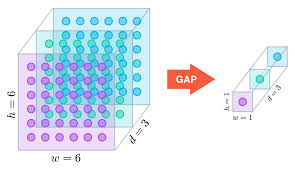

In [ ]:
def compute_embeddings(dataloader):
    """
    Compute latent embeddings for all images in `dataloader` using `model` CNN.
    
    dataloader:
        torch.utils.data.DataLoader
    
    return:
    X:
        tensor, shape: (len(dataloader.dataset), 512), dtype: float32, device: 'cpu'
    y:
        tensor, shape: (len(dataloader.dataset),)    , dtype: int64  , device: 'cpu'
    """
    model.eval()
    X, y = [], []

    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            embeddings = model.features(images.to(DEVICE)).mean([2, 3])

            X.append(embeddings.cpu())
            y.append(labels)

    return torch.cat(X), torch.cat(y)

In [ ]:
X_train, y_train = compute_embeddings(train_dataloader)
X_val  , y_val   = compute_embeddings(  val_dataloader)

assert X_train.shape == (len(train_dataloader.dataset), 512)
assert y_train.shape == (len(train_dataloader.dataset),)

Train a random forest classifier on the embeddings that we just precomputed.

In [ ]:
import sklearn.ensemble
import sklearn.metrics

classifier = sklearn.ensemble.RandomForestClassifier()
classifier.fit(X_train, y_train);

In [ ]:
train_accuracy = sklearn.metrics.accuracy_score(y_train, classifier.predict(X_train))
val_accuracy   = sklearn.metrics.accuracy_score(y_val  , classifier.predict(X_val))

print(f"Train accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation accuracy: {val_accuracy * 100:.2f}%")

### 4. Replace the last layers and retrain them

The above approach isn't very convenient because we have to run a separate algorithm.

It's more convenient to add a neural network on top of `model.features` instead of a random forest. This way, our pipeline becomes **end-to-end**: a single `torch.nn.Module` directly outputs the prediction we need (the probabilities of "tower/dome/..." classes).

Still, don't expect the accuracy to be much higher than with random forest. We just replaced it with a simple two-layer neural net, nothing more.

In [ ]:
class RetrofittedCNN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        pretrained_net = torchvision.models.squeezenet1_1(
            pretrained=True,
            num_classes=1000)
        self.CNN = pretrained_net.features

        self.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, len(class_names))
        )

    def forward(self, images):
        """
        Define the forward pass.
        """
        features = self.CNN(images).mean([2, 3])
        class_scores = self.classifier(features)
        return class_scores

torch.manual_seed(666) # for reproducibility
model = RetrofittedCNN().to(DEVICE)
model.CNN.requires_grad_(False);

Set the optimization parameters.

Note that we only want to train the classifier!

In [ ]:
trainable_parameters = model.classifier.parameters()

learning_rate = 3e-3
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

criterion = torch.nn.CrossEntropyLoss()

Describe the training loop.

In [ ]:
def validate(model, dataloader):
    """Compute accuracy on the `dataloader` dataset."""
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            labels = labels.to(DEVICE)
            dog_probabilities = model(images.to(DEVICE))
            predictions = dog_probabilities.max(1)[1]

            total += len(labels)
            correct += (predictions == labels).sum().item()
            
    return correct / total

def train(model, dataloader, criterion, optimizer):
    """Train for one epoch, return accuracy and average loss."""
    model.train()

    correct, total = 0, 0
    total_loss = 0.0

    for images, labels in tqdm(dataloader):
        probabilities = model(images.to(DEVICE))

        with torch.no_grad():
            labels = labels.to(DEVICE)
            predictions = probabilities.max(1)[1]
            
            total += len(labels)
            correct += (predictions == labels).sum().item()

        loss_value = criterion(probabilities, labels)
        total_loss += loss_value.item() * len(labels)
        
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
    
    return correct / total, total_loss / total

In [ ]:
def set_learning_rate(optimizer, new_learning_rate):
    """Set learning rates of the optimizer to `new_learning_rate`."""
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_learning_rate

In [ ]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [ ]:
for _ in range(18):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (4, 8, 12):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

# Compute final validation accuracy
val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

It looks like the neural network classifier generalizes better than random forest. Anyway, they both are limited by the "frozen" CNN.

### 5. Fine-tune the whole network

We have seen that `model.features` is already a good feature extractor. Still, it's not aware of our dataset.

Let's train **all** layers (including our new retrofitted classifier) to get extra accuracy. This process is called **fine-tuning**.

Because the original `model.features`' weights are valuable, fragile and co-adapted, fine-tuning requires several precautions:

* If the retrofitted classifier's weights are random, it will propagate large gradients into the pre-trained CNN. That can wreck the pre-trained weights. That's why one should either
  * train the retrofitted classifier alone for a while (**we've just done this**); or
  * assign a larger learning rate to the classifier and a smaller one to pre-trained weights (e.g. $10^{-2}$ and $10^{-4}$ with SGD); or
  * (an option for the lazy) train everything with a reduced learning rate (e.g. $10^{-3}$).
* Use a less aggressive optimizer, e.g. momentum SGD, Adam with warm-up (**we do this below**), or RAdam.
* Use a smaller learning rate than usually. **Below I used $\leq 10^{-4}$**, while on random weights I'd use something around $10^{-3}$.

In [ ]:
# Don't forget to turn gradient computing back on; "unfreeze" the CNN
model.CNN.requires_grad_(True);

Here, we set zero learning rate to warm Adam up.

Warm-up means running some iterations without any weight updates, just to let Adam accumulate gradient statistics. Otherwise, its first optimization steps will be very noisy and destructive for the pre-trained weights.

In [ ]:
# Now the parameters have to include both CNN's and classifier's weights
trainable_parameters = model.parameters()

# Note the zero learning rate
learning_rate = 0
optimizer = torch.optim.Adam(
    trainable_parameters, lr=learning_rate, weight_decay=1e-4)

Run 1 epoch of warm-up.


In [ ]:
train(model, train_dataloader, criterion, optimizer);

Switch back to a positive learning rate. Remember, it should be smaller than usual (above, we used $3 \cdot 10^{-3}$).

In [ ]:
learning_rate = 8e-5
set_learning_rate(optimizer, learning_rate)

Finally, fine-tune the model.

In [ ]:
epochs = 0
train_accuracy, val_accuracy, train_loss = float('nan'), float('nan'), float('nan')

In [ ]:
for _ in range(15):
    # Compute validation accuracy
    val_accuracy = validate(model, val_dataloader)
    print(
        f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
        f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

    # Train for one epoch
    train_accuracy, train_loss = train(model, train_dataloader, criterion, optimizer)
    epochs += 1

    # Decrease learning rate sometimes
    if epochs in (7, 12):
        learning_rate /= 10
        set_learning_rate(optimizer, learning_rate)
        print(f"Decreasing the learning rate to {learning_rate}")

val_accuracy = validate(model, val_dataloader)
print(
    f"After {epochs} epochs, training accuracy: {train_accuracy * 100:.2f}%"
    f" (loss {train_loss:.4f}), validation accuracy: {val_accuracy * 100:.2f}%")

We decreased the validation error by a couple of percent, which is great!

Also, note how the training loss was stuck in the previous run, but started to go to zero after we gave model extra capacity by "unfreezing" the pre-trained weights.

## 6. Conclusions

* Fine-tuning is an extremely important technique. It's ubiquitous in deep learning. Make sure to master it.
* Almost all of you will need it in final course projects.
* Starting from pre-trained weights is almost always better than starting from random ones,
* ...and is actually the only solution when your dataset is small.
* Fine-tuning has to be done very carefully, with proper intuition and commonly known tricks (see above).